<a href="https://colab.research.google.com/github/Anand7Choudhary/QuantitativeAnalysis_MarketRiskAnalysis/blob/main/QuantitativeAnalysis_MarketRiskAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Analysis and In-Depth Market Risk Assessment of a Stock Portfolio


In [47]:
!pip install arch

## Data Acquisition and Preparation

In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import norm

In [49]:
try:
    # Define the stock tickers (use .NS for NSE listed stocks)
    tickers = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS", "TCS.NS", "ICICIBANK.NS", "^NSEI"]  # Added NIFTY 50 index
    # Download data
    data = yf.download(tickers, start="2019-01-01", end="2024-12-21")

    # Extract adjusted closing prices
    adj_close = data['Adj Close']

    # Handle MultiIndex for multiple stocks
    if len(tickers) > 1:
        adj_close = data['Adj Close']

    #If you want to download for a single stock
    else:
        raise ValueError("No tickers provided")

    # Handle missing values using forward fill then backward fill
    adj_close = adj_close.ffill()  # Create a copy with missing values filled
    adj_close = adj_close.bfill()  # Create another copy and fill remaining missing values

    # Check if any missing values remain
    if adj_close.isnull().values.any():
        print("Warning: Missing values still present after forward/backward fill.")
        # Handle them more appropriately if needed (e.g., interpolation)
        adj_close.interpolate(method='linear', inplace=True)
        if adj_close.isnull().values.any():
            raise ValueError("Missing values still present after interpolation.")

    # Check for duplicate dates
    if adj_close.index.duplicated().any():
        print("Duplicate dates found. Removing duplicates.")
        adj_close = adj_close[~adj_close.index.duplicated(keep='first')]

    # Descriptive Statistics
    print("\nDescriptive Statistics:\n", adj_close.describe())

    # Ensure the index is datetime
    adj_close.index = pd.to_datetime(adj_close.index)

    # Calculate daily log returns
    returns = np.log(adj_close / adj_close.shift(1))
    returns.dropna(inplace=True) #remove first row which has NaN due to shift operation


    # Get Market Caps (using info attribute)
    market_caps = {}
    for ticker in tickers[:-1]:  # Exclude the index
        try:
            ticker_info = yf.Ticker(ticker).info
            market_caps[ticker] = ticker_info['marketCap']
        except (KeyError, IndexError, TypeError):
            print(f"Could not retrieve market cap for {ticker}. Using a default value of 1 for weighting")
            market_caps[ticker] = 1

    # Calculate market cap weights
    total_market_cap = sum(market_caps.values())
    weights = np.array([market_caps[ticker] / total_market_cap for ticker in tickers[:-1]])

    # Calculate portfolio returns using market cap weights
    portfolio_returns = (returns[tickers[:-1]] * weights).sum(axis=1)
    returns['Portfolio_MarketCap'] = portfolio_returns

    # Portfolio Creation using Equal weights
    num_stocks = len(tickers) -1 # exclude nifty index
    weights_equal = np.array([1/num_stocks] * num_stocks)

    # Calculate portfolio returns
    portfolio_returns_equal = (returns[tickers[:-1]] * weights_equal).sum(axis=1)

    # Add portfolio returns to the returns DataFrame
    returns['Portfolio_Equal'] = portfolio_returns_equal

    print("Market Caps:", market_caps)
    print("Market Cap Weights:", weights)

    print(returns.head())
    print(returns.tail())
    returns.to_csv("indian_stock_returns.csv")
    print("Returns data saved to indian_stock_returns.csv")

except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

[*********************100%***********************]  6 of 6 completed



Descriptive Statistics:
 Ticker  HDFCBANK.NS  ICICIBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS  \
count   1475.000000   1475.000000  1475.000000  1475.000000  1475.000000   
mean    1373.650629    714.598775  1226.175836  1015.044101  2947.468493   
std      230.810228    280.529536   405.460471   287.042325   775.326176   
min      736.975525    274.531067   468.411102   394.334839  1505.618408   
25%     1186.365540    453.097046   720.325867   818.656769  2050.745972   
50%     1425.025513    698.274536  1350.153687  1080.490601  3093.847412   
75%     1557.278076    917.214081  1516.500366  1196.244141  3455.165039   
max     1871.750000   1346.099976  1999.699951  1590.069946  4542.667969   

Ticker         ^NSEI  
count    1475.000000  
mean    16338.086243  
std      4398.607852  
min      7610.250000  
25%     11911.875000  
50%     16929.599609  
75%     18814.599609  
max     26216.050781  
Market Caps: {'RELIANCE.NS': 16526442758144, 'HDFCBANK.NS': 13635007021056, 'INFY.

In [50]:
try:
    # Define the stock tickers (use .NS for NSE listed stocks)
    tickers = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS", "TCS.NS", "ICICIBANK.NS", "^NSEI"]  # Added NIFTY 50 index
    # Download data
    data = yf.download(tickers, start="2019-01-01", end="2024-12-21")

    # Extract adjusted closing prices
    adj_close = data['Adj Close']

    # Handle MultiIndex for multiple stocks
    if len(tickers) > 1:
        adj_close = data['Adj Close']
    else:
        raise ValueError("No tickers provided")

    # Handle missing values using forward fill then backward fill
    adj_close = adj_close.ffill()  # Create a copy with missing values filled
    adj_close = adj_close.bfill()  # Create another copy and fill remaining missing values

    # Check if any missing values remain
    if adj_close.isnull().values.any():
        print("Warning: Missing values still present after forward/backward fill.")
        adj_close.interpolate(method='linear', inplace=True)
        if adj_close.isnull().values.any():
            raise ValueError("Missing values still present after interpolation.")

    # Check for duplicate dates
    if adj_close.index.duplicated().any():
        print("Duplicate dates found. Removing duplicates.")
        adj_close = adj_close[~adj_close.index.duplicated(keep='first')]

    # Descriptive Statistics
    print("\nDescriptive Statistics:\n", adj_close.describe())

    # Ensure the index is datetime
    adj_close.index = pd.to_datetime(adj_close.index)

    # Calculate daily log returns
    returns = np.log(adj_close / adj_close.shift(1))
    returns.dropna(inplace=True)  # Remove first row which has NaN due to shift operation

    # Get Market Caps (using info attribute)
    market_caps = {}
    for ticker in tickers[:-1]:  # Exclude the index
        try:
            ticker_info = yf.Ticker(ticker).info
            market_caps[ticker] = ticker_info['marketCap']
        except (KeyError, IndexError, TypeError):
            print(f"Could not retrieve market cap for {ticker}. Using a default value of 1 for weighting")
            market_caps[ticker] = 1

    # Calculate market cap weights
    total_market_cap = sum(market_caps.values())
    weights = np.array([market_caps[ticker] / total_market_cap for ticker in tickers[:-1]])

    # Calculate portfolio returns using market cap weights
    portfolio_returns = (returns[tickers[:-1]] * weights).sum(axis=1)
    returns['Portfolio_MarketCap'] = portfolio_returns

    # Portfolio Creation using Equal weights
    num_stocks = len(tickers) - 1  # Exclude NIFTY index
    weights_equal = np.array([1 / num_stocks] * num_stocks)

    # Calculate portfolio returns
    portfolio_returns_equal = (returns[tickers[:-1]] * weights_equal).sum(axis=1)

    # Add portfolio returns to the returns DataFrame
    returns['Portfolio_Equal'] = portfolio_returns_equal

    # Add portfolio returns to adj_close DataFrame as well
    adj_close['Portfolio_MarketCap'] = (portfolio_returns + 1).cumprod() * adj_close.iloc[0, 0]  # Scale to starting price
    adj_close['Portfolio_Equal'] = (portfolio_returns_equal + 1).cumprod() * adj_close.iloc[0, 0]  # Scale to starting price

    print("Market Caps:", market_caps)
    print("Market Cap Weights:", weights)

    print(returns.head())
    print(returns.tail())
    print(adj_close.head())
    print(adj_close.tail())

    # Save data to CSV
    returns.to_csv("indian_stock_returns.csv")
    adj_close.to_csv("indian_stock_adj_close.csv")

    print("Returns data saved to indian_stock_returns.csv")
    print("Adjusted closing prices data saved to indian_stock_adj_close.csv")

except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

[*********************100%***********************]  6 of 6 completed



Descriptive Statistics:
 Ticker  HDFCBANK.NS  ICICIBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS  \
count   1475.000000   1475.000000  1475.000000  1475.000000  1475.000000   
mean    1373.650629    714.598775  1226.175836  1015.044101  2947.468493   
std      230.810228    280.529536   405.460471   287.042325   775.326176   
min      736.975525    274.531067   468.411102   394.334839  1505.618408   
25%     1186.365540    453.097046   720.325867   818.656769  2050.745972   
50%     1425.025513    698.274536  1350.153687  1080.490601  3093.847412   
75%     1557.278076    917.214081  1516.500366  1196.244141  3455.165039   
max     1871.750000   1346.099976  1999.699951  1590.069946  4542.667969   

Ticker         ^NSEI  
count    1475.000000  
mean    16338.086243  
std      4398.607852  
min      7610.250000  
25%     11911.875000  
50%     16929.599609  
75%     18814.599609  
max     26216.050781  
Market Caps: {'RELIANCE.NS': 16526442758144, 'HDFCBANK.NS': 13635007021056, 'INFY.

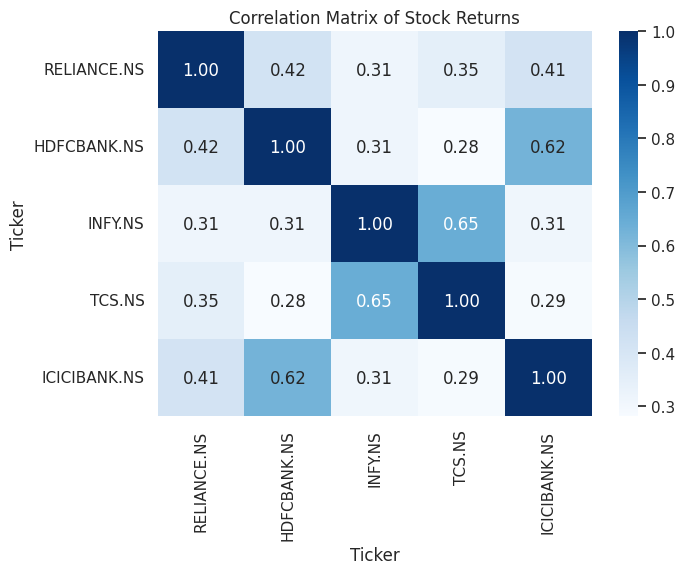

In [51]:
try:
  # Calculate correlation matrix
  correlation_matrix = returns[tickers[:-1]].corr()
  # Create heatmap
  plt.figure(figsize=(7, 5))
  sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
  plt.title("Correlation Matrix of Stock Returns")
  plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

The heatmap visualizes the correlation matrix, which shows the pairwise linear relationships between the daily log returns of the stocks in your portfolio. The color intensity and the annotated values indicate the strength and direction of the correlation.

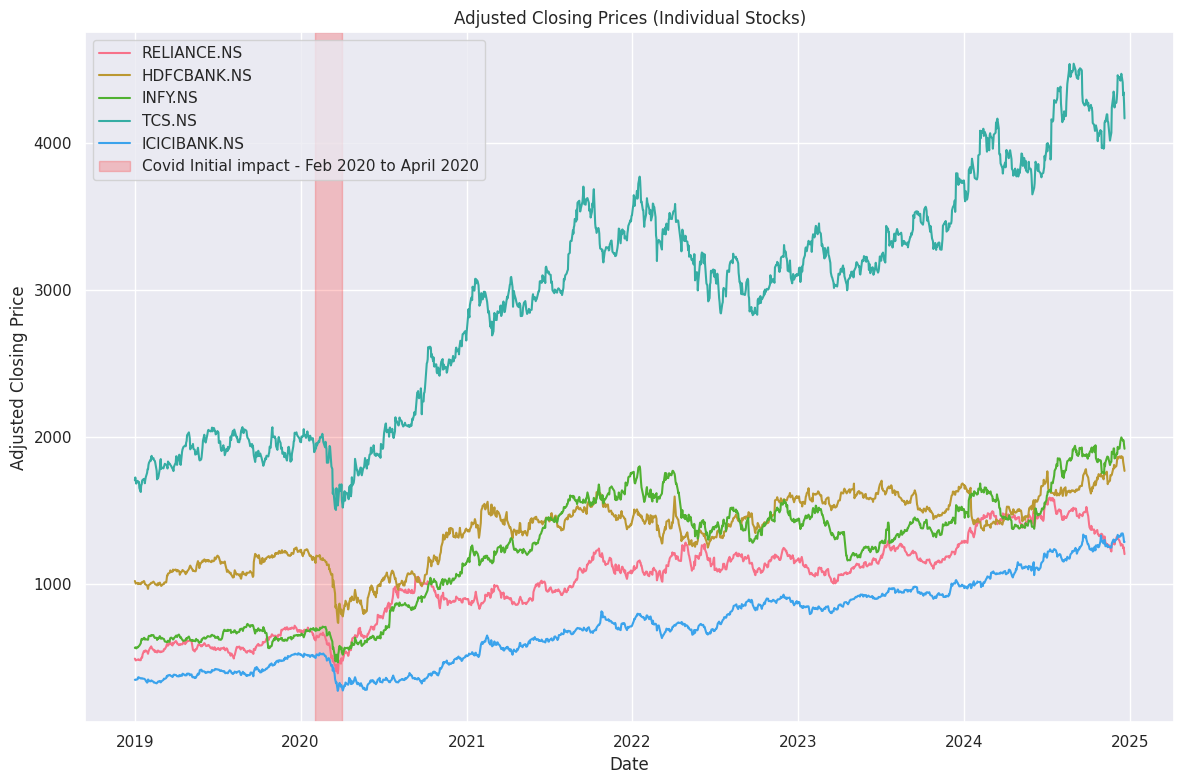

In [52]:
try:
  # Plot cumulative returns
    # Plot adjusted closing prices for each stock (excluding NIFTY)
    plt.figure(figsize=(12, 8))  # Set figure size for better readability
    for ticker in tickers[:-1]:  # Exclude the last ticker (NIFTY)
        plt.plot(adj_close[ticker], label=ticker)

    # Add red shaded area from March 2020 to March 2022
    plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-04-01"),
            color='red', alpha=0.2, label="Covid Initial impact - Feb 2020 to April 2020")
    plt.title("Adjusted Closing Prices (Individual Stocks)")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Closing Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

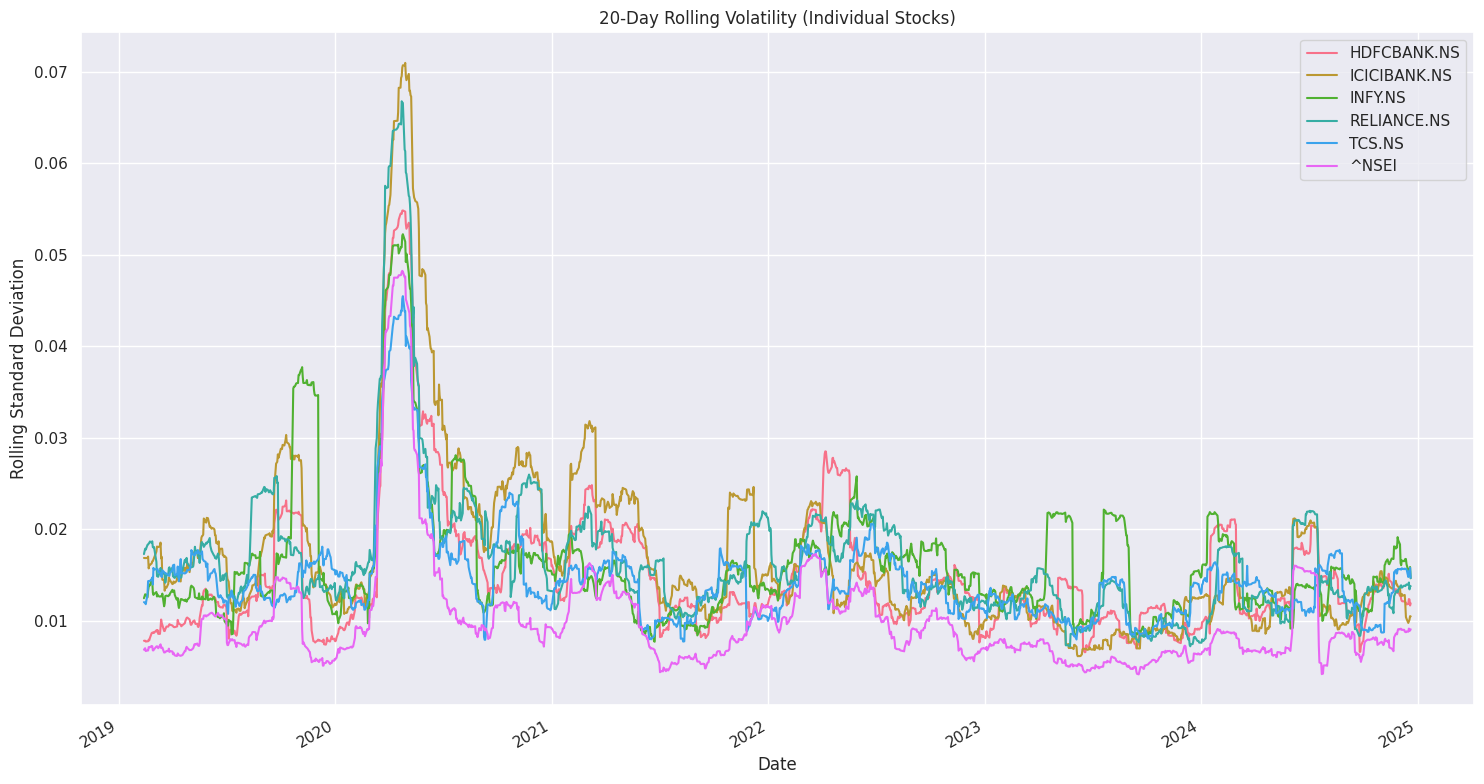

In [53]:
try:
  # Calculate rolling volatility (excluding the last column, which is assumed to be portfolio returns)
  rolling_volatility = returns.iloc[:, :-2].rolling(window=30).std()  # Select all columns except the last one
  # Plot 20-day rolling volatility
  rolling_volatility.plot(figsize=(15, 8))
  plt.title("20-Day Rolling Volatility (Individual Stocks)")
  plt.xlabel("Date")
  plt.ylabel("Rolling Standard Deviation")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Plotting the rolling (or moving) standard deviation of returns over time can show how volatility changes over different periods. This is very useful for understanding how risk fluctuates.

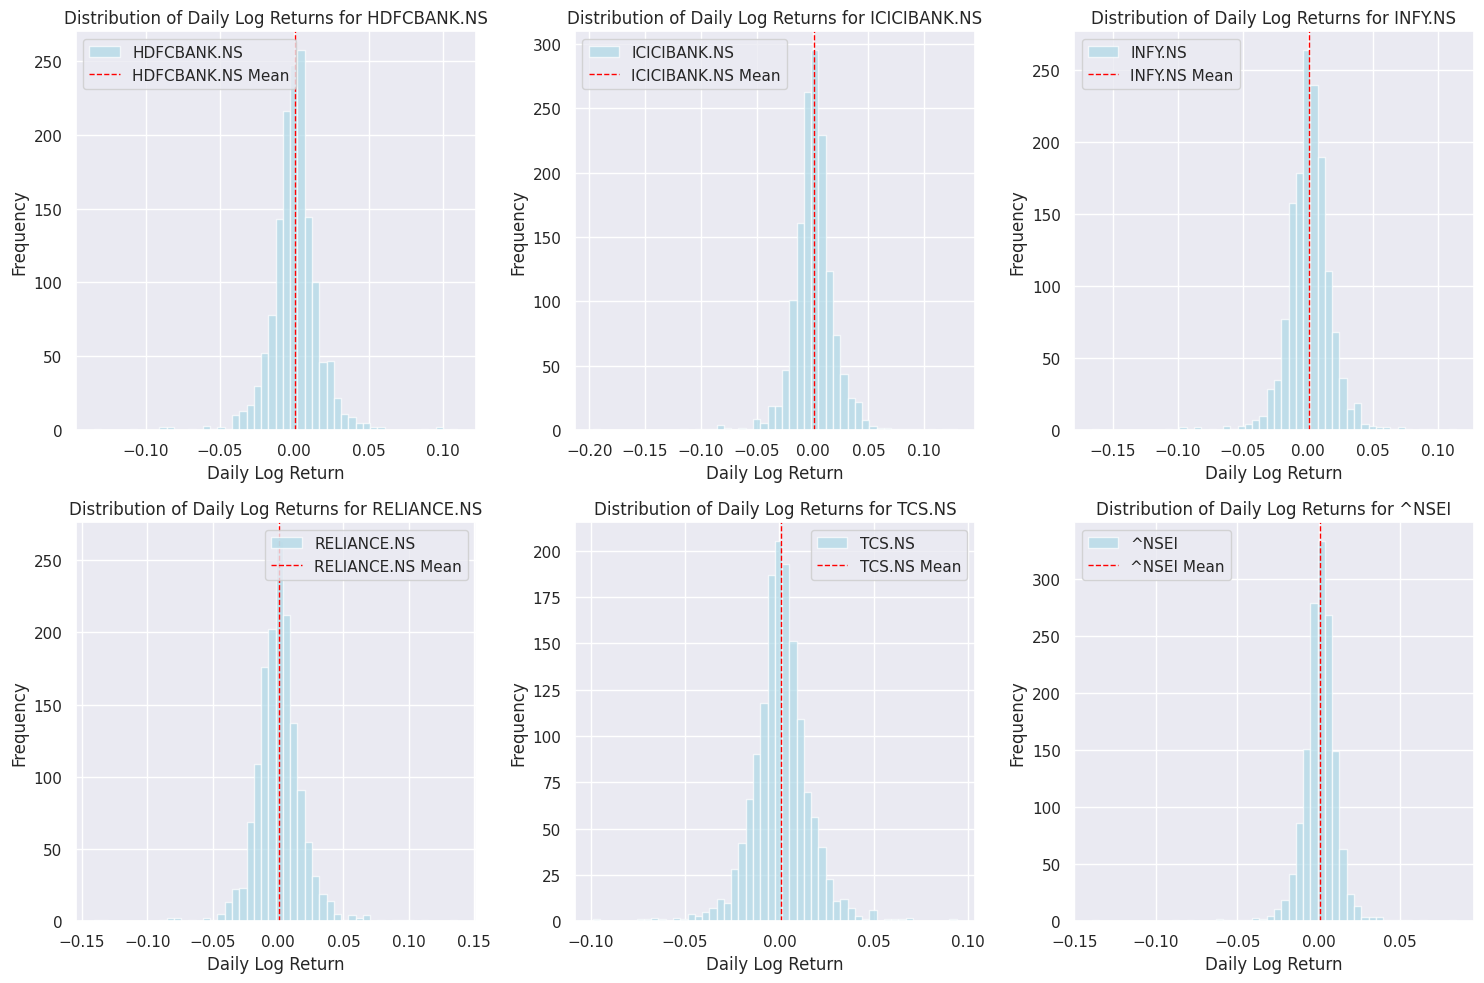

In [64]:
try:
   # Plot separate return distribution histograms for each stock (excluding NIFTY)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Create subplots
    axes = axes.flatten() # Flatten the axes array for easier indexing

    for i, ticker in enumerate(returns.columns[:-2]):  # Iterate through all columns except the last one ('Portfolio_Equal')
        ax = axes[i] # Select the current axes
        returns[ticker].hist(ax=ax, bins=50, alpha=0.7, label=ticker, color='lightblue') # Plot on the current axes
        mean_return = returns[ticker].mean()
        ax.axvline(mean_return, color='red', linestyle='dashed', linewidth=1, label=f"{ticker} Mean")
        ax.set_title(f"Distribution of Daily Log Returns for {ticker}")
        ax.set_xlabel("Daily Log Return")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Distribution Graph of Log Returns (Histograms):

Explanation: These histograms show the distribution of daily log returns for each stock. They provide insights into the statistical properties of the returns.
Insights:
Normality: If the histogram resembles a bell-shaped curve (normal distribution), it suggests that the returns are approximately normally distributed. Deviations from normality (skewness and kurtosis) are common in financial data.
Skewness:
Positive Skew (Right Skew): The distribution has a longer tail on the right side, indicating more frequent small losses and fewer large gains.
Negative Skew (Left Skew): The distribution has a longer tail on the left side, indicating more frequent small gains and fewer large losses.
Kurtosis: Measures the "tailedness" of the distribution. High kurtosis indicates heavier tails (more extreme values or "fat tails") than a normal distribution.

## Quantitative Analysis

## Statistics Analysis

In [55]:
try:
    # Mean and Standard Deviation of returns
    mean_returns = returns.mean()
    std_returns = returns.std()

    # Skewness and Kurtosis for distribution shape
    skewness = returns.skew()
    kurtosis = returns.kurt()

    # Print the results
    print(f"Mean Returns:\n{mean_returns}")
    print(f"Standard Deviation (Volatility):\n{std_returns}")
    print(f"Skewness:\n{skewness}")
    print(f"Kurtosis:\n{kurtosis}")

except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Mean Returns:
Ticker
HDFCBANK.NS            0.000373
ICICIBANK.NS           0.000884
INFY.NS                0.000828
RELIANCE.NS            0.000605
TCS.NS                 0.000605
^NSEI                  0.000530
Portfolio_MarketCap    0.000623
Portfolio_Equal        0.000659
dtype: float64
Standard Deviation (Volatility):
Ticker
HDFCBANK.NS            0.016535
ICICIBANK.NS           0.019774
INFY.NS                0.017589
RELIANCE.NS            0.018441
TCS.NS                 0.015268
^NSEI                  0.011668
Portfolio_MarketCap    0.012521
Portfolio_Equal        0.012604
dtype: float64
Skewness:
Ticker
HDFCBANK.NS           -0.362398
ICICIBANK.NS          -0.674734
INFY.NS               -0.684565
RELIANCE.NS            0.116872
TCS.NS                -0.121423
^NSEI                 -1.588182
Portfolio_MarketCap   -0.843926
Portfolio_Equal       -0.967242
dtype: float64
Kurtosis:
Ticker
HDFCBANK.NS             9.467375
ICICIBANK.NS           12.424073
INFY.NS                10.

## ADF test


Analysis for HDFCBANK.NS:
ADF Statistic: -9.721130029531619
p-value: 9.53750000187403e-17
Series is likely stationary.


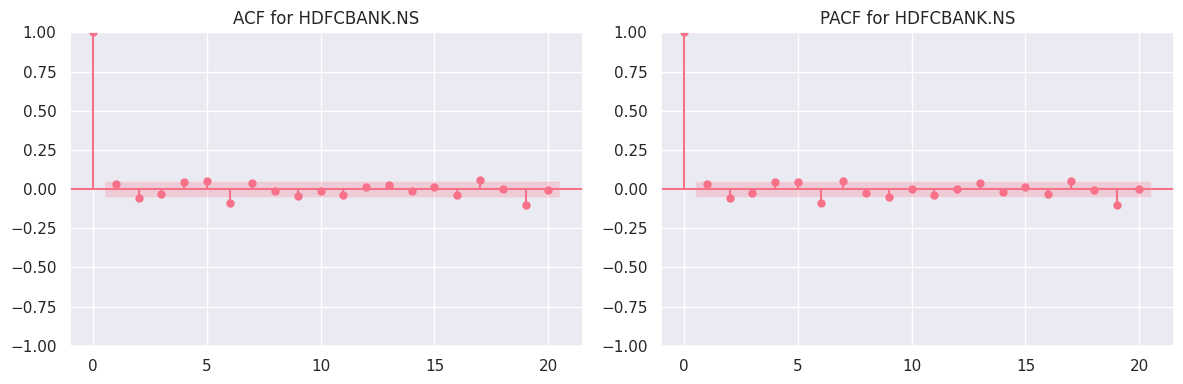


Analysis for ICICIBANK.NS:
ADF Statistic: -9.418619945993626
p-value: 5.580964962137456e-16
Series is likely stationary.


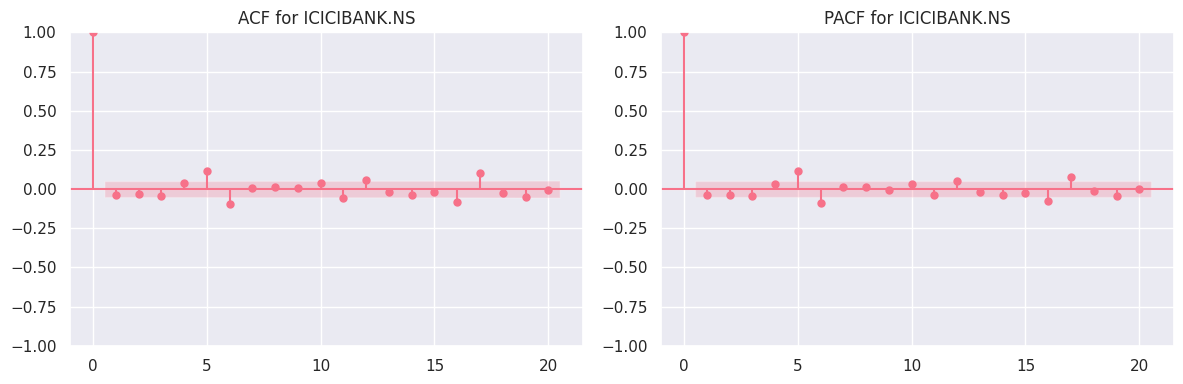


Analysis for INFY.NS:
ADF Statistic: -14.537468736805241
p-value: 5.210821379596306e-27
Series is likely stationary.


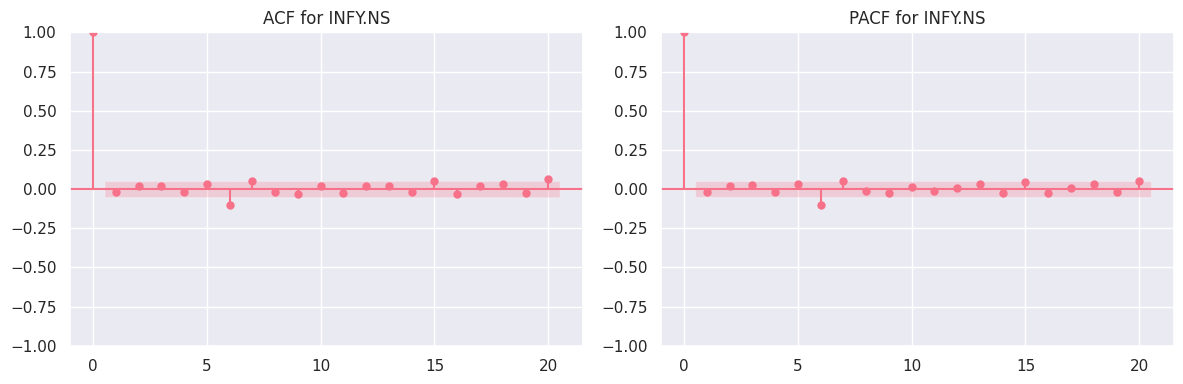


Analysis for RELIANCE.NS:
ADF Statistic: -11.446561247355362
p-value: 5.9987345015604385e-21
Series is likely stationary.


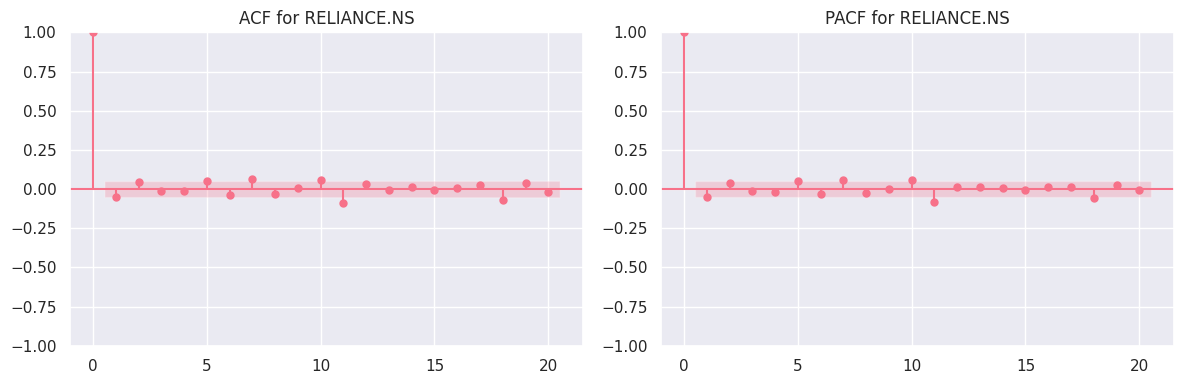


Analysis for TCS.NS:
ADF Statistic: -39.383785279066146
p-value: 0.0
Series is likely stationary.


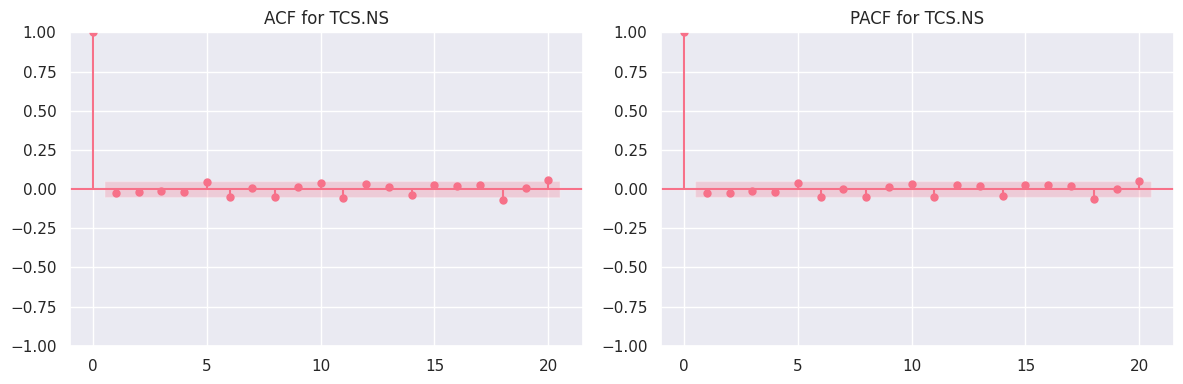


Analysis for ^NSEI:
ADF Statistic: -11.223981114564616
p-value: 1.981464193081205e-20
Series is likely stationary.


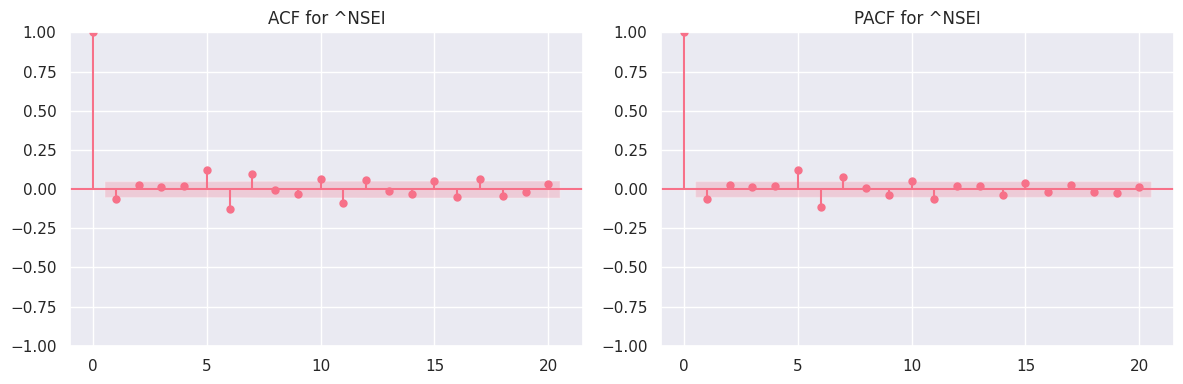


Analysis for Portfolio_MarketCap:
ADF Statistic: -12.037566674801978
p-value: 2.780304669552944e-22
Series is likely stationary.


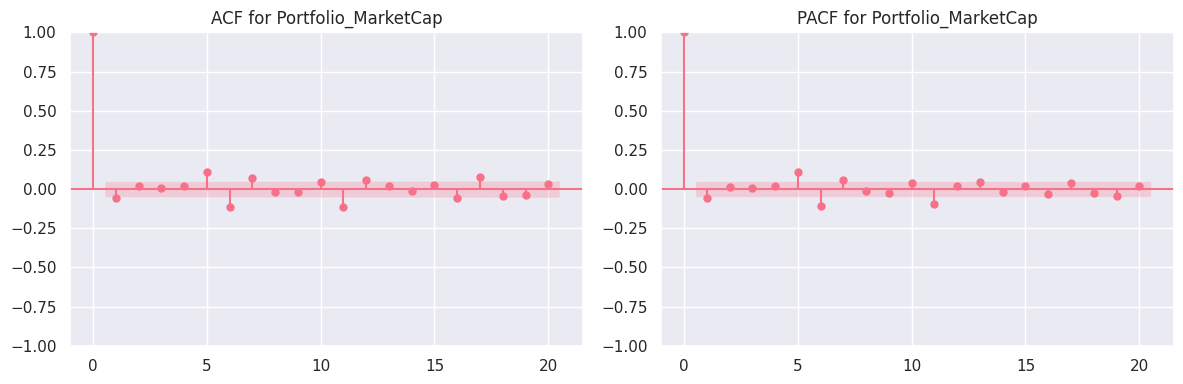


Analysis for Portfolio_Equal:
ADF Statistic: -7.797959992368836
p-value: 7.627583984503317e-12
Series is likely stationary.


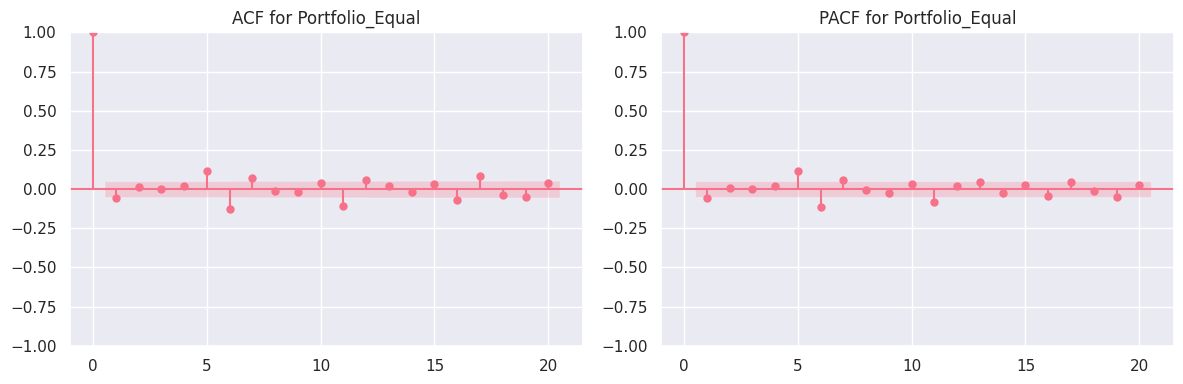

In [61]:
try:
  for ticker in returns.columns:
    print(f"\nAnalysis for {ticker}:")
    # Stationarity Testing (ADF Test)
    adf_result = adfuller(returns[ticker])
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] > 0.05:
      print("Series is likely non-stationary.")
    else:
      print("Series is likely stationary.")

    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(returns[ticker], lags=20, ax=axes[0])
    plot_pacf(returns[ticker], lags=20, ax=axes[1])
    axes[0].set_title(f"ACF for {ticker}")
    axes[1].set_title(f"PACF for {ticker}")
    plt.tight_layout()
    plt.show()
except ValueError as e:
  print(f"ValueError: {e}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

## Time Series Analysis

In [57]:
try:
  def fit_enhanced_model(prices, returns, ticker, forecast_period=30):
    """
    Enhanced forecasting model that accounts for recent trends and volatility
    """
    try:
        # Convert inputs to pandas Series
        prices = pd.Series(prices)
        returns = pd.Series(returns)

        # Calculate recent trend (last 20 days)
        recent_prices = prices.tail(20)
        trend = (recent_prices.iloc[-1] - recent_prices.iloc[0]) / recent_prices.iloc[0]
        trend_daily = trend / 20  # Average daily trend

        print(f"\nDebugging {ticker}:")
        print(f"Recent {20}-day trend: {trend:.2%}")
        print(f"Average daily trend: {trend_daily:.2%}")

        # Calculate recent volatility (last 20 days)
        recent_returns = returns.tail(20)
        recent_vol = recent_returns.std()
        print(f"Recent volatility: {recent_vol:.2%}")

        # Clean returns data
        clean_returns = returns.copy()
        clean_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
        clean_returns.fillna(clean_returns.mean(), inplace=True)

        # Fit ARIMA model with trend component
        print("Fitting ARIMA model...")
        model = ARIMA(clean_returns, order=(2, 1, 2))  # Changed to ARIMA(2,1,2) to capture trends
        results = model.fit()

        # Generate return forecasts
        returns_forecast = results.forecast(steps=forecast_period)

        # Adjust forecasts based on recent trend and volatility
        returns_forecast = returns_forecast + trend_daily  # Add trend component

        # Add randomness based on recent volatility
        np.random.seed(42)  # For reproducibility
        noise = np.random.normal(0, recent_vol/2, forecast_period)
        returns_forecast = returns_forecast + noise

        # Calculate forecasted prices
        last_price = float(prices.iloc[-1])
        forecast_prices = []
        current_price = last_price

        # Convert returns to prices with momentum effect
        momentum = trend_daily * 0.5  # Momentum factor
        for i, ret in enumerate(returns_forecast):
            # Add decreasing momentum effect
            momentum_effect = momentum * (1 - i/forecast_period)
            adjusted_return = float(ret) + momentum_effect
            next_price = current_price * (1 + adjusted_return)
            forecast_prices.append(next_price)
            current_price = next_price

        # Create confidence intervals with expanding uncertainty
        lower_bound = []
        upper_bound = []
        for i in range(forecast_period):
            # Increase uncertainty over time
            time_factor = np.sqrt(i + 1)
            interval = recent_vol * time_factor
            price = forecast_prices[i]
            lower = price * (1 - 1.96 * interval)
            upper = price * (1 + 1.96 * interval)
            lower_bound.append(lower)
            upper_bound.append(upper)

        # Create forecast index
        forecast_index = pd.date_range(
            start=prices.index[-1] + pd.Timedelta(days=1),
            periods=forecast_period,
            freq='B'
        )

        # Convert to pandas Series
        forecast_prices = pd.Series(forecast_prices, index=forecast_index)
        lower_bound = pd.Series(lower_bound, index=forecast_index)
        upper_bound = pd.Series(upper_bound, index=forecast_index)

        print("\nForecast Summary:")
        print(f"Starting price: {last_price:.2f}")
        print(f"Ending price: {forecast_prices.iloc[-1]:.2f}")
        print(f"Predicted change: {((forecast_prices.iloc[-1]/last_price - 1) * 100):.2f}%")

        return forecast_prices, lower_bound, upper_bound

    except Exception as e:
        print(f"Critical error in forecasting {ticker}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

  def plot_forecast(prices, forecast_prices, lower_bound, upper_bound, ticker):
      """
      Enhanced plotting function with better visualization
      """
      plt.figure(figsize=(12, 6))

      # Plot historical data (last 100 points)
      historical_subset = prices.tail(100)
      plt.plot(historical_subset.index, historical_subset.values,
              label='Historical', color='blue', linewidth=2)

      # Plot forecast
      plt.plot(forecast_prices.index, forecast_prices.values,
              label='Forecast', color='red', linestyle='--', linewidth=2)

      # Plot confidence intervals
      plt.fill_between(forecast_prices.index,
                      lower_bound.values,
                      upper_bound.values,
                      color='red', alpha=0.2,
                      label='95% Confidence Interval')

      # Add trend lines
      last_historical = historical_subset.iloc[-20:]
      z = np.polyfit(range(len(last_historical)), last_historical.values, 1)
      p = np.poly1d(z)
      plt.plot(last_historical.index, p(range(len(last_historical))),
              color='green', linestyle='--', alpha=0.8, linewidth=1, label='Recent Trend')

      # Add grid and style improvements
      plt.title(f'{ticker} Price Forecast', fontsize=14, pad=20)
      plt.grid(True, alpha=0.3)
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('Price', fontsize=12)

      # Ensure all labels are included
      plt.legend(loc='best', fontsize=10)

      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")


Processing forecasts for RELIANCE.NS

Debugging RELIANCE.NS:
Recent 20-day trend: -6.35%
Average daily trend: -0.32%
Recent volatility: 1.25%
Fitting ARIMA model...

Forecast Summary:
Starting price: 1205.30
Ending price: 1050.42
Predicted change: -12.85%


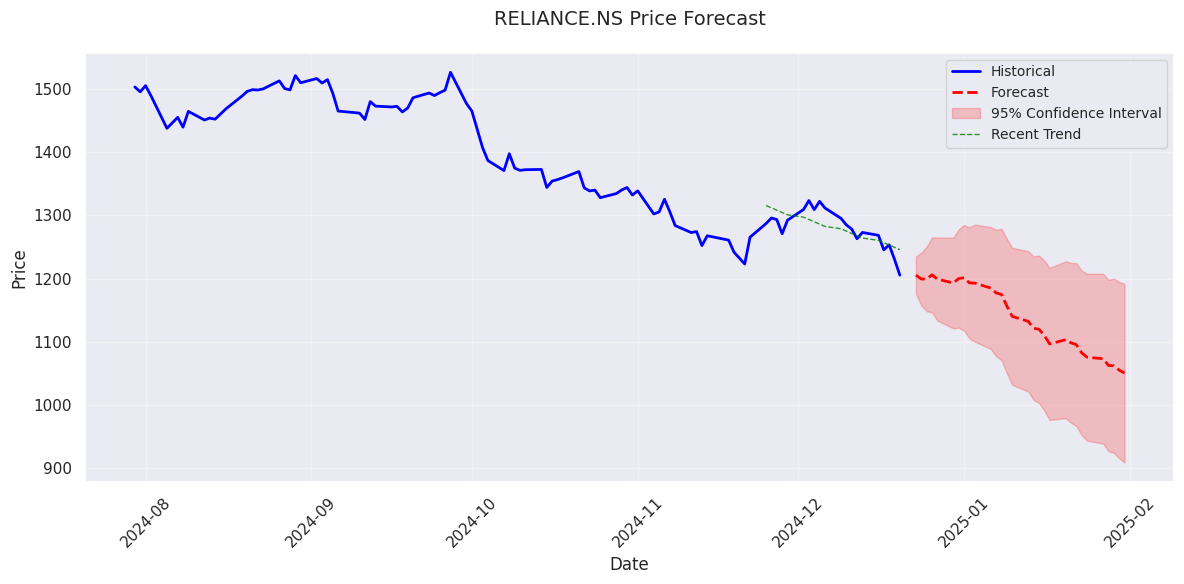


Processing forecasts for HDFCBANK.NS

Debugging HDFCBANK.NS:
Recent 20-day trend: -0.79%
Average daily trend: -0.04%
Recent volatility: 1.08%
Fitting ARIMA model...

Forecast Summary:
Starting price: 1771.50
Ending price: 1711.25
Predicted change: -3.40%


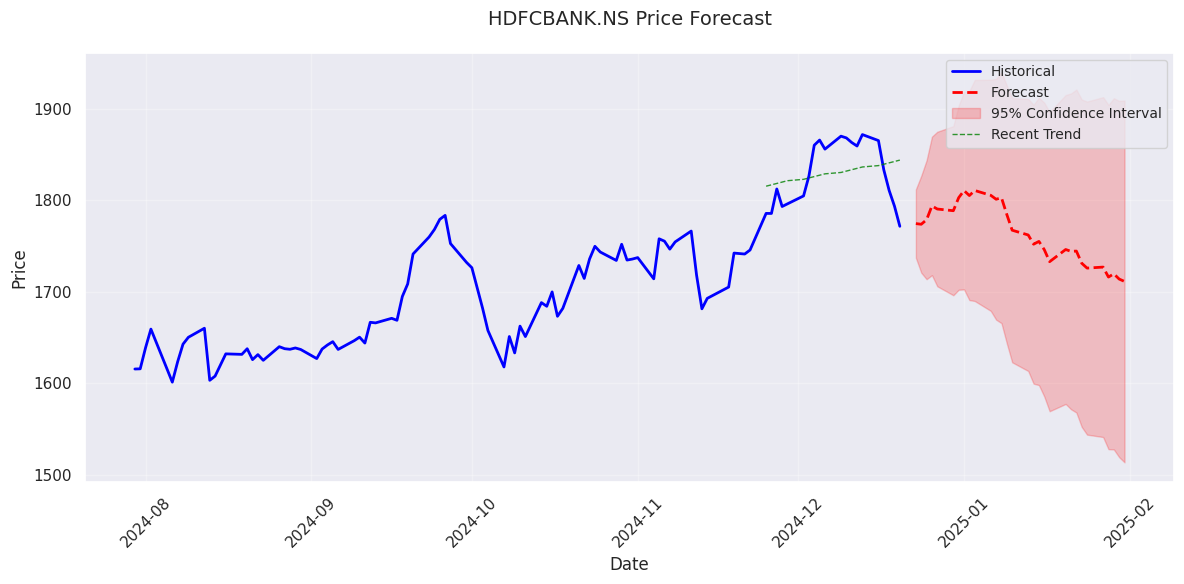


Processing forecasts for INFY.NS

Debugging INFY.NS:
Recent 20-day trend: 1.72%
Average daily trend: 0.09%
Recent volatility: 1.34%
Fitting ARIMA model...

Forecast Summary:
Starting price: 1922.15
Ending price: 1956.17
Predicted change: 1.77%


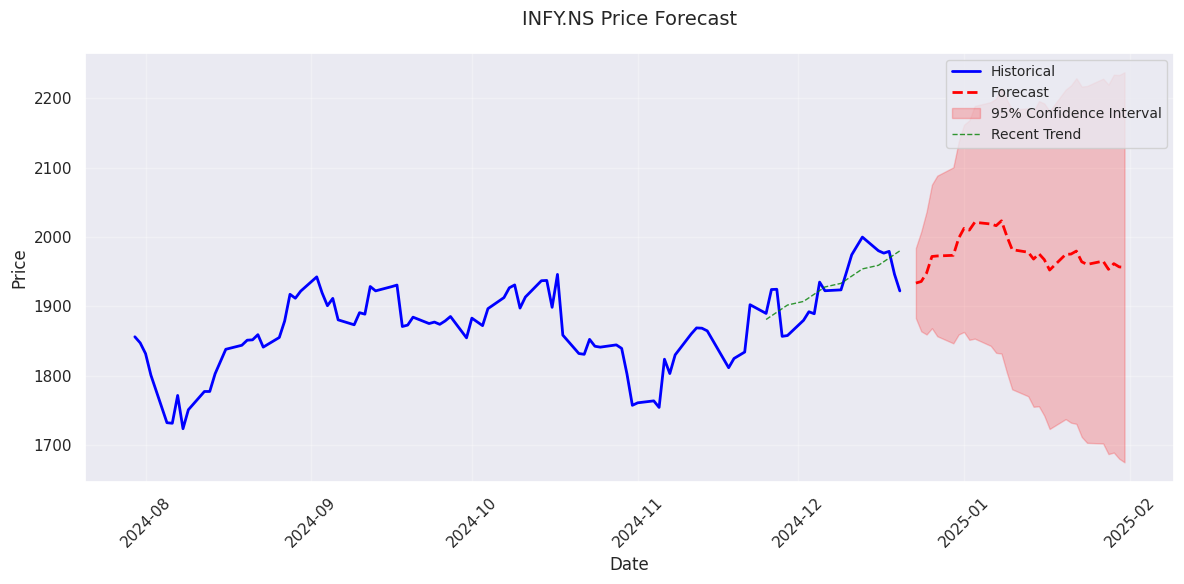


Processing forecasts for TCS.NS

Debugging TCS.NS:
Recent 20-day trend: -3.36%
Average daily trend: -0.17%
Recent volatility: 1.29%
Fitting ARIMA model...

Forecast Summary:
Starting price: 4170.30
Ending price: 3836.30
Predicted change: -8.01%


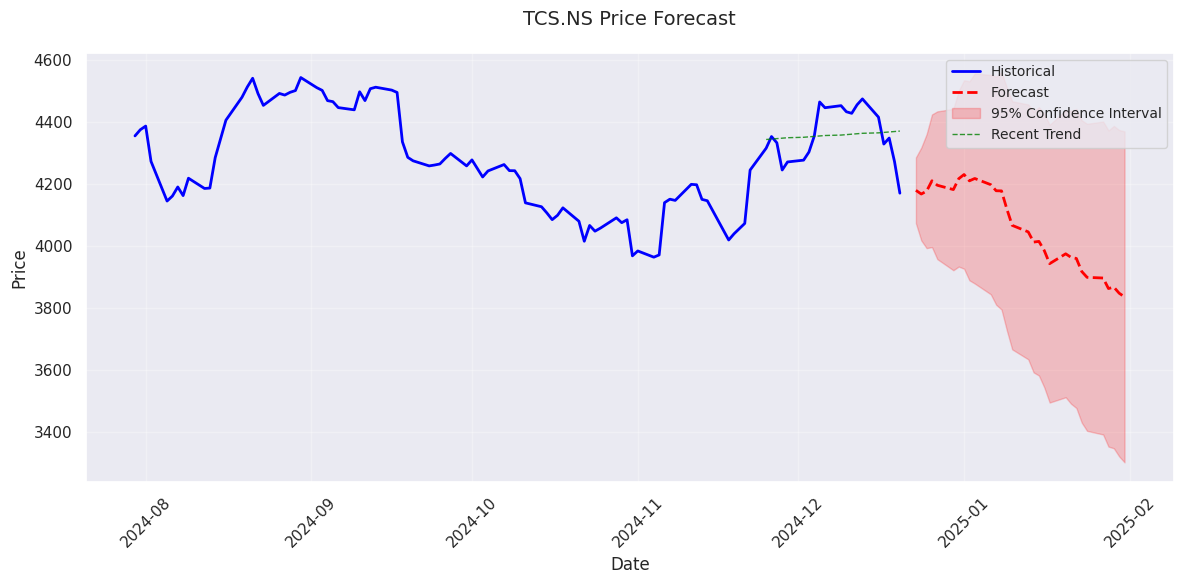


Processing forecasts for ICICIBANK.NS

Debugging ICICIBANK.NS:
Recent 20-day trend: -0.96%
Average daily trend: -0.05%
Recent volatility: 0.99%
Fitting ARIMA model...

Forecast Summary:
Starting price: 1288.40
Ending price: 1262.85
Predicted change: -1.98%


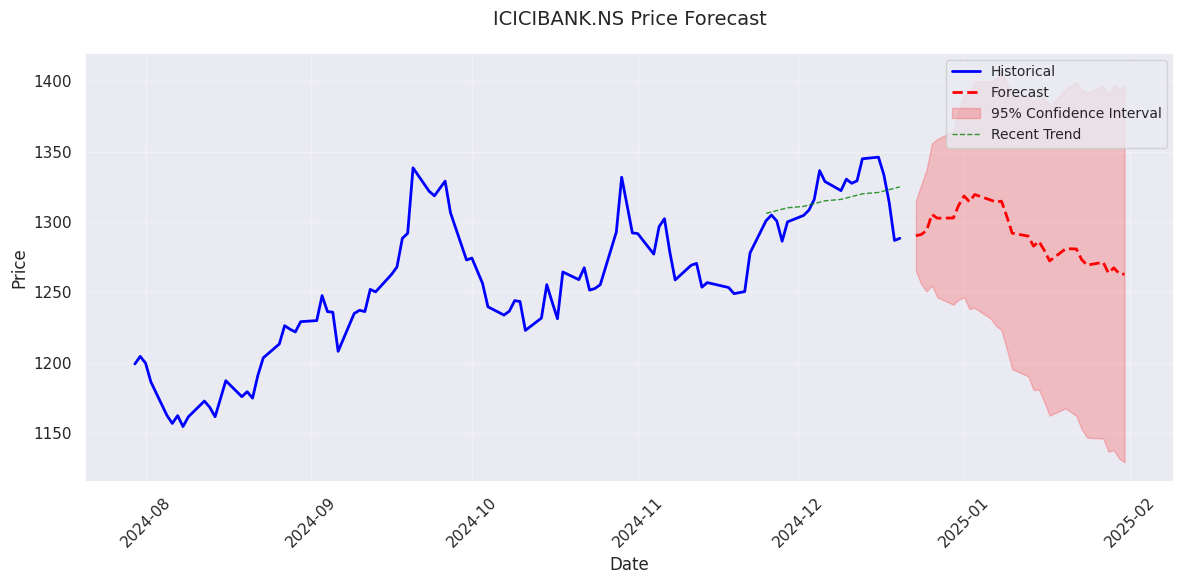

In [58]:
try:
  for ticker in tickers:
    if ticker == '^NSEI':
        continue

    print(f"\nProcessing forecasts for {ticker}")
    stock_returns = returns[ticker].copy()
    stock_prices = adj_close[ticker].copy()

    forecast_results = fit_enhanced_model(
        stock_prices,
        stock_returns,
        ticker,
        forecast_period
    )

    if forecast_results is not None:
        forecast_prices, lower_bound, upper_bound = forecast_results
        plot_forecast(stock_prices, forecast_prices, lower_bound, upper_bound, ticker)
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

## Market Risk Analysis

In [59]:
try:
  # --- Market Risk Analysis Functions ---

  def historical_var_calc(returns, confidence_level=0.95):
      """Calculates historical VaR (as a return)."""
      return np.percentile(returns, (1 - confidence_level) * 100)

  def parametric_var(returns, confidence_level=0.95):
      """Calculates parametric VaR (as a return) assuming normal distribution."""
      z_score = norm.ppf(confidence_level)
      return returns.mean() - z_score * returns.std()

  def expected_shortfall(returns, confidence_level=0.95):
      """Calculates Expected Shortfall (ES) or CVaR (as a return)."""
      var = historical_var_calc(returns, confidence_level)
      tail_losses = returns[returns <= var]
      return tail_losses.mean()

  def stress_test(returns, scenario_return=-0.10):
      """Applies a stress test scenario to returns."""
      return returns * (1 + scenario_return)

  def sharpe_ratio(returns, risk_free_rate=0.05/252):
      """Calculates the Sharpe Ratio (annualized)."""
      excess_returns = returns - risk_free_rate
      return np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

  def monte_carlo_var(returns, num_simulations=10000, confidence_level=0.95):
      simulations = np.random.choice(returns, size=num_simulations, replace=True)
      var_value = np.percentile(simulations, (1 - confidence_level) * 100)
      return var_value

  def expected_shortfall(returns, var_value, confidence_level=0.95):
      es_returns = returns[returns <= var_value]
      es_value = es_returns.mean()
      return es_value

  def convert_to_price(risk_value, portfolio_value):
      return risk_value * portfolio_value
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

1. Historical Simulation VaR in price terms: ₹-16526.99 (Return: -1.65%)
2. Parametric VaR in price terms: ₹-20072.46 (Return: -2.01%)
3. Monte Carlo Simulation VaR in price terms: ₹-15695.15 (Return: -1.57%)
4. Expected Shortfall (ES) in price terms: ₹659.16 (Return: 0.07%)
5. Stressed VaR in price terms: ₹ -13221.59 (Return: -1.32%)
6. Sharpe Ratio: 0.58

Impact of Market Crash:
Portfolio value after Market Crash: ₹900000.00

Impact of Stock Shock (Reliance):
Portfolio value after Stock Shock (Reliance): ₹850000.00

Impact of Stock Shock (HDFCBank):
Portfolio value after Stock Shock (HDFCBank): ₹880000.00


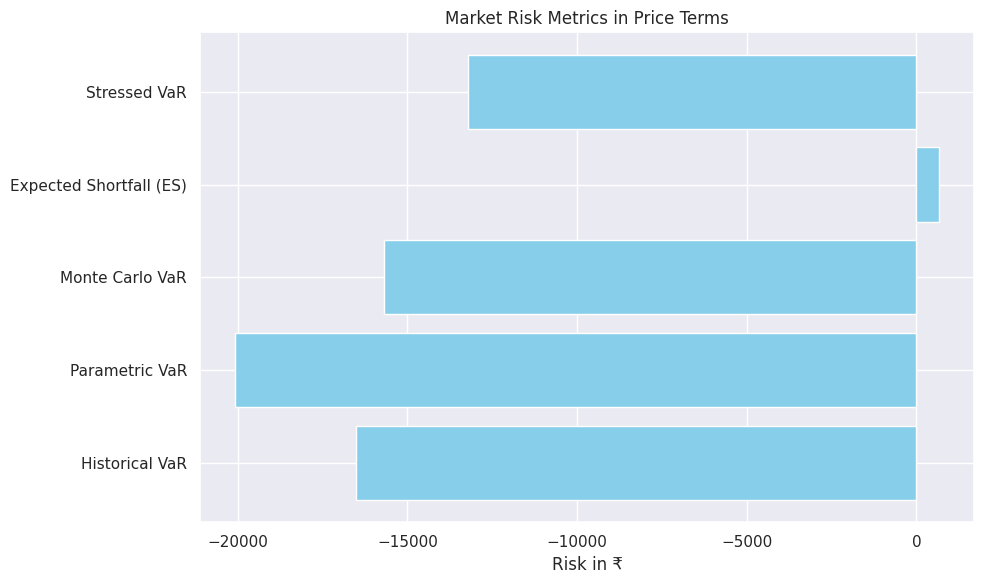

In [60]:
try:
  # --- Market Risk Analysis ---
  fixed_portfolio_value = 1000000
  confidence_level = 0.95

  historical_var_return = historical_var_calc(portfolio_returns_equal, confidence_level)
  historical_var_price = fixed_portfolio_value * historical_var_return

  parametric_var_return = parametric_var(portfolio_returns_equal, confidence_level)
  parametric_var_price = fixed_portfolio_value * parametric_var_return

  es_return = expected_shortfall(portfolio_returns_equal, confidence_level)
  es_price = fixed_portfolio_value * es_return

  monte_carlo_var_in_returns = monte_carlo_var(returns['Portfolio_Equal'])
  monte_carlo_var_in_price = convert_to_price(monte_carlo_var_in_returns, fixed_portfolio_value)

  stressed_returns = stress_test(portfolio_returns_equal, -0.20)
  stressed_var_return = historical_var_calc(stressed_returns, confidence_level)
  stressed_var_price = fixed_portfolio_value * stressed_var_return

  sharpe = sharpe_ratio(portfolio_returns_equal)

  # Print the results
  print(f"1. Historical Simulation VaR in price terms: ₹{historical_var_price:.2f} (Return: {historical_var_return*100:.2f}%)")
  print(f"2. Parametric VaR in price terms: ₹{parametric_var_price:.2f} (Return: {parametric_var_return*100:.2f}%)")
  print(f"3. Monte Carlo Simulation VaR in price terms: ₹{monte_carlo_var_in_price:.2f} (Return: {monte_carlo_var_in_returns*100:.2f}%)")
  print(f"4. Expected Shortfall (ES) in price terms: ₹{es_price:.2f} (Return: {es_return*100:.2f}%)")
  print(f"5. Stressed VaR in price terms: ₹ {stressed_var_price:.2f} (Return: {stressed_var_return*100:.2f}%)")
  print(f"6. Sharpe Ratio: {sharpe:.2f}")

  # Stress Testing and Scenario Analysis
  # Define stress test scenarios (e.g., market crash, specific stock shock)
  stress_scenarios = {
      'Market Crash': -0.1,  # 10% drop in portfolio value
      'Stock Shock (Reliance)': -0.15,  # 15% drop in Reliance stock
      'Stock Shock (HDFCBank)': -0.12,  # 12% drop in HDFCBank stock
  }

  # Apply stress scenarios and calculate the impact on portfolio value
  for scenario, return_shock in stress_scenarios.items():
      portfolio_value_after_shock = fixed_portfolio_value * (1 + return_shock)
      print(f"\nImpact of {scenario}:")
      print(f"Portfolio value after {scenario}: ₹{portfolio_value_after_shock:.2f}")

  # Visualize the results
  risk_metrics = [
      ('Historical VaR', historical_var_price),
      ('Parametric VaR', parametric_var_price),
      ('Monte Carlo VaR', monte_carlo_var_in_price),
      ('Expected Shortfall (ES)', es_price),
      ('Stressed VaR', stressed_var_price)
  ]

  # Prepare data for plotting
  risk_names = [x[0] for x in risk_metrics]
  risk_values = [x[1] for x in risk_metrics]

  # Plot the risk metrics
  plt.figure(figsize=(10, 6))
  plt.barh(risk_names, risk_values, color='skyblue')
  plt.xlabel('Risk in ₹')
  plt.title('Market Risk Metrics in Price Terms')
  plt.tight_layout()
  plt.show()
except ValueError as e:
    print(f"ValueError: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")